# 회고

early stopping을 넣었다고 하더라도
운이 나쁘면(최적의 지점을 빨리 찾지 못하면) 에포크를 끝까지 다 돌아봐야 할 수도 있다는 것을 깨달았다.

완전히 동일한 조건에서 아래 조건의 모델을 여러번 돌려봤을 때,  
- 동일한 모델
- epoch = 100
- early stopping을 넣음

어떨 땐 에포크 10만에 끝나기도 했고, 어떨 땐 에포크 100까지 전부 가야지만 끝나는 경우가 있었다.(생각해보면 당연한거지만...)

에포크가 끝까지 돌아가는 경우가 많을 경우, 학습률을 조금 키우면 전체 에포크 수를 줄이는 것에 도움이 될 수 있을 듯 하다.   
best 방법은, 아래 예시처럼 **"학습률 스케쥴러"**를 써서    
monitor 지표의 개선이 없을 시 자동으로 학습률을 조정하는 방법을 쓰는 게 좋다고 한다.   

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Step 0. 필요한 패키지 import

In [48]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# Step 1. 데이터셋 내려받기

In [39]:
# ✅ train 70%, val 15%, test 15%로 분할
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [40]:
# ✅ 전처리 이유: EfficientNet은 (224, 224) 크기 + float 타입만 처리 가능
IMG_SIZE = (224, 224)  # EfficientNet 기본 입력 크기
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image) # EfficientNet 전용 정규화 (/ 255.0 하면 안됨)
    return image, label

train_batches = ds_train.map(format_image, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_batches = ds_validation.map(format_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_batches = ds_test.map(format_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Step 3. 모델 설계하기

In [41]:
# ✅ EfficientNet 모델 선정 이유:
# - VGG16보다 정확도 우수 (VGG16도 실험했으나, 정확도 50% 수준이었음...)
# - 파라미터 수 적고 모바일 환경에 최적화됨 (앱에 올릴거니까...)
# - 최신 아키텍처 기반

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # ✅ Transfer learning - Feature Extractor 부분 동결

# ✅ FC 레이어 설계 이유:
# - Flatten 대신 GlobalAvgPooling: 파라미터 수 줄이기
# - Dropout: overfitting 방지
# - Dense(5): tf_flowers는 5개 클래스

global_avg = tf.keras.layers.GlobalAveragePooling2D()
dropout = tf.keras.layers.Dropout(0.3)
output = tf.keras.layers.Dense(5, activation='softmax') # ✅ Dense layer(분류기) 부분만 학습

model = tf.keras.Sequential([
    base_model,
    global_avg,
    dropout,
    output
])

# Step 4. 모델 학습시키기

In [42]:
# ✅ 하이퍼파라미터 선정 이유:
# - Adam: 빠른 수렴
# - Learning Rate 0.0001: 과적합 최소화
# - Loss: sparse_categorical_crossentropy → 라벨이 정수로 제공됨

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',      # 검증 손실 기준 (정확도보다 손실이 노이즈에 덜 민감하며 변화 감지에 강함)
    patience=3,              # 3 epoch 동안 개선 없으면 멈춤
    restore_best_weights=True  # 가장 좋았던 weight 복원
)

# 학습 시작
history = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=100,  # 10 -> 15 에포크 증가시키면서 성능 개선 확인하였으며, 아예100으로 늘리고 early stopping을 넣는 방향으로 개선하였음
    callbacks=[early_stopping]
)

Epoch 1/100
81/81 [==============================] - 18s 95ms/step - loss: 1.5675 - accuracy: 0.3056 - val_loss: 1.2901 - val_accuracy: 0.5681
Epoch 2/100
81/81 [==============================] - 6s 74ms/step - loss: 1.2118 - accuracy: 0.5660 - val_loss: 1.0271 - val_accuracy: 0.7205
Epoch 3/100
81/81 [==============================] - 6s 74ms/step - loss: 1.0056 - accuracy: 0.6905 - val_loss: 0.8638 - val_accuracy: 0.7750
Epoch 4/100
81/81 [==============================] - 6s 74ms/step - loss: 0.8614 - accuracy: 0.7571 - val_loss: 0.7560 - val_accuracy: 0.8058
Epoch 5/100
81/81 [==============================] - 6s 73ms/step - loss: 0.7689 - accuracy: 0.7808 - val_loss: 0.6802 - val_accuracy: 0.8348
Epoch 6/100
81/81 [==============================] - 6s 73ms/step - loss: 0.6976 - accuracy: 0.7980 - val_loss: 0.6231 - val_accuracy: 0.8421
Epoch 7/100
81/81 [==============================] - 6s 73ms/step - loss: 0.6386 - accuracy: 0.8167 - val_loss: 0.5787 - val_accuracy: 0.8512
Epoch

# Step 5. 모델 성능 평가하기

18/18 [==============================] - 1s 57ms/step - loss: 0.1795 - accuracy: 0.9364

✅ Test Accuracy: 93.64%



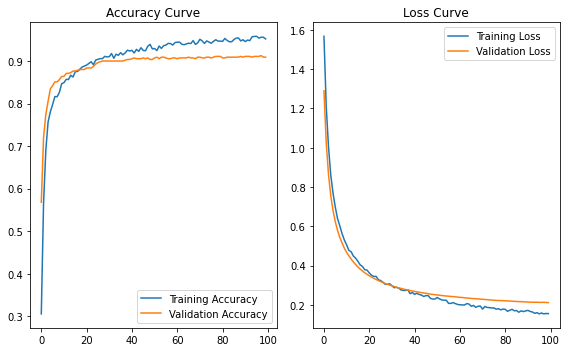

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curve')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss Curve')
plt.tight_layout()
plt.savefig("training_plot.png")

test_loss, test_acc = model.evaluate(test_batches)
print(f"\n✅ Test Accuracy: {test_acc:.2%}\n")

# Step 6. 모델 활용하기

In [55]:
# ✅ 모델 저장 (Flutter 연동 위해 TFLite 변환 구조로 저장)
model_dir = "efficientnet_flower_model"
model.save(model_dir)

# TFLite 변환
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()

with open("efficientnet_flower_model.tflite", "wb") as f:
    f.write(tflite_model)

    
    
# ✅ 인터넷에서 가져온 이미지 실험해보기
builder = tfds.builder('tf_flowers')
class_names = builder.info.features['label'].names

# ✅ 테스트 이미지 파일 리스트
image_paths = [
    'daisy_test.jpg',
    'dandelion_test.jpg',
    'rose_test.jpeg',
    'sunflower_test.jpeg',
    'tulip_test.jpg'
]

# ✅ 하나씩 예측해보기
for img_path in image_paths:
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # EfficientNet용 전처리
    from tensorflow.keras.applications.efficientnet import preprocess_input
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx]
    label = class_names[class_idx]

    print(f"{img_path} → {label} ({confidence:.2%})")

INFO:tensorflow:Assets written to: efficientnet_flower_model/assets


INFO:tensorflow:Assets written to: efficientnet_flower_model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


daisy_test.jpg → daisy (84.22%)
dandelion_test.jpg → dandelion (100.00%)
rose_test.jpeg → roses (86.71%)
sunflower_test.jpeg → sunflowers (82.63%)
tulip_test.jpg → tulips (98.60%)
